# SHAP with structured data classification

**Explainable AI with TensorFlow, Keras and SHAP**

*This code tutorial is mainly based on the Keras tutorial ["Structured data classification from scratch"](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/) by François Chollet and ["Census income classification with Keras"](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html#Census-income-classification-with-Keras) by Scott Lundberg.*

- To keep this tutorial simple, we will only use numerical features in our binary classification example. 
- Take a look at [](structured_data_classification_layers.ipynb) to see an example of how to use more advanced Keras data preprocessing layers.

## Setup

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import shap

tf.__version__

'2.8.1'

In [2]:
# print the JS visualization code to the notebook
shap.initjs()

## Data

Here's the description of the data:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | normal; fixed defect; reversible defect | Categorical (string)
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

We will only use the following continuous numerical features to predict the variable "Target" (diagnosis of heart disease):

- `age`
- `trestbps`
- `chol`
- `thalach`
- `oldpeak`
- `slope`

### Data import


- Let's download the data and load it into a Pandas dataframe:

In [3]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)

### Data preparation

In [4]:
# make target variable
y = df.pop('target')

In [5]:
# prepare features
list_numerical = ['age', 'thalach', 'trestbps',  'chol', 'oldpeak']

X = df[list_numerical]

### Data splitting

- Let's split the data into a training and test set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature preprocessing

In [7]:
scaler = StandardScaler().fit(X_train[list_numerical]) 

X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

## Model

Now we can build the model using the Keras sequential API:

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

In [9]:
model.compile(optimizer="adam", 
              loss ="binary_crossentropy", 
              metrics=["accuracy"])

Let's visualize our connectivity graph:

In [11]:
model.fit(X_train, y_train, 
         epochs=15, 
         batch_size=13,
         validation_data=(X_test, y_test)
         )

Epoch 1/15
 1/19 [>.............................] - ETA: 2s - loss: 0.7202 - accuracy: 0.2308

2022-06-17 21:27:28.476252: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


19/19 [==============================] - 0s 4ms/step - loss: 0.7119 - accuracy: 0.3967 - val_loss: 0.7118 - val_accuracy: 0.4754
Epoch 2/15
19/19 [==============================] - 0s 1ms/step - loss: 0.6848 - accuracy: 0.5124 - val_loss: 0.6894 - val_accuracy: 0.4590
Epoch 3/15
19/19 [==============================] - 0s 1ms/step - loss: 0.6650 - accuracy: 0.6157 - val_loss: 0.6705 - val_accuracy: 0.6557
Epoch 4/15
19/19 [==============================] - 0s 1ms/step - loss: 0.6477 - accuracy: 0.6818 - val_loss: 0.6566 - val_accuracy: 0.6885
Epoch 5/15
19/19 [==============================] - 0s 1ms/step - loss: 0.6311 - accuracy: 0.7397 - val_loss: 0.6434 - val_accuracy: 0.7377
Epoch 6/15
19/19 [==============================] - 0s 1ms/step - loss: 0.6161 - accuracy: 0.7479 - val_loss: 0.6301 - val_accuracy: 0.7377
Epoch 7/15
19/19 [==============================] - 0s 1ms/step - loss: 0.6015 - accuracy: 0.7893 - val_loss: 0.6170 - val_accuracy: 0.7377
Epoch 8/15
19/19 [=============

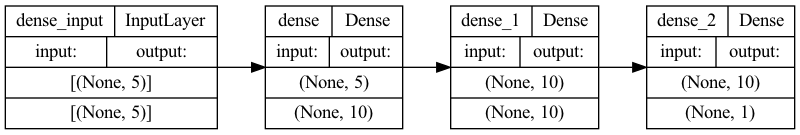

In [12]:
# `rankdir='LR'` is to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [13]:
loss, accuracy = model.evaluate(X_test, y_test)

print("Accuracy", accuracy)

2/2 [==============================] - 0s 1ms/step - loss: 0.5534 - accuracy: 0.7869
Accuracy 0.7868852615356445


## Perform inference

- Let's save the heart diseases classification model to demonstrate the process of a real world scenario (where we would first save the model and reload it in a different production environment):

In [13]:
model.save('classifier_hd')

INFO:tensorflow:Assets written to: classifier_hd/assets


2022-06-12 17:01:00.553972: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


- Load the model:

In [14]:
reloaded_model = tf.keras.models.load_model('classifier_hd')

In [15]:
predictions = reloaded_model.predict(X_train)

In [16]:
print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)

This particular patient had a 24.8 percent probability of having a heart disease, as evaluated by our model.


## SHAP

We use our model and a selection of 50 samples from the dataset to represent “typical” feature values (the so called background distribution).

In [17]:
explainer = shap.KernelExplainer(model, X_train.iloc[:50,:])

Now we use 500 perterbation samples to estimate the SHAP values for a given prediction (at index location 20). Note that this requires 500 * 50 evaluations of the model.

In [18]:
shap_values = explainer.shap_values(X_train.iloc[20,:], nsamples=500)

The so called force plot below shows how each feature contributes to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. To learn more about force plots, take a look at this [Nature BME paper](https://www.nature.com/articles/s41551-018-0304-0.epdf?author_access_token=vSPt7ryUfdSCv4qcyeEuCdRgN0jAjWel9jnR3ZoTv0PdqacSN9qNY_fC0jWkIQUd0L2zaj3bbIQEdrTqCczGWv2brU5rTJPxyss1N4yTIHpnSv5_nBVJoUbvejyvvjrGTb2odwWKT2Bfvl0ExQKhZw%3D%3D) from Lundberg et al. (2018).

In [19]:
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[20,:])

### Explain many predictions

If we take many force plot explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (see content below). Here, we repeat the above explanation process for 50 individuals.

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in the dependent variable. Vertical dispersion at a single value of represents interaction effects with other features. 

In [20]:
shap_values50 = explainer.shap_values(X_train.iloc[50:100,:], nsamples=500)

  0%|          | 0/50 [00:00<?, ?it/s]

In [21]:
shap.force_plot(explainer.expected_value, shap_values50[0], X_train.iloc[50:100,:])